<h1 align="center" style="font-variant: small-caps">How to build a genome-scale cell growth model</h1>
<h2 align="center">TUTORIAL 4 &mdash; Model reduction to convex problem</h2>
<h5 align="center">(<code>Version 14</code>, June 2025)</h5>

<div align="center" style="max-width:100px;display:block;margin:auto;">

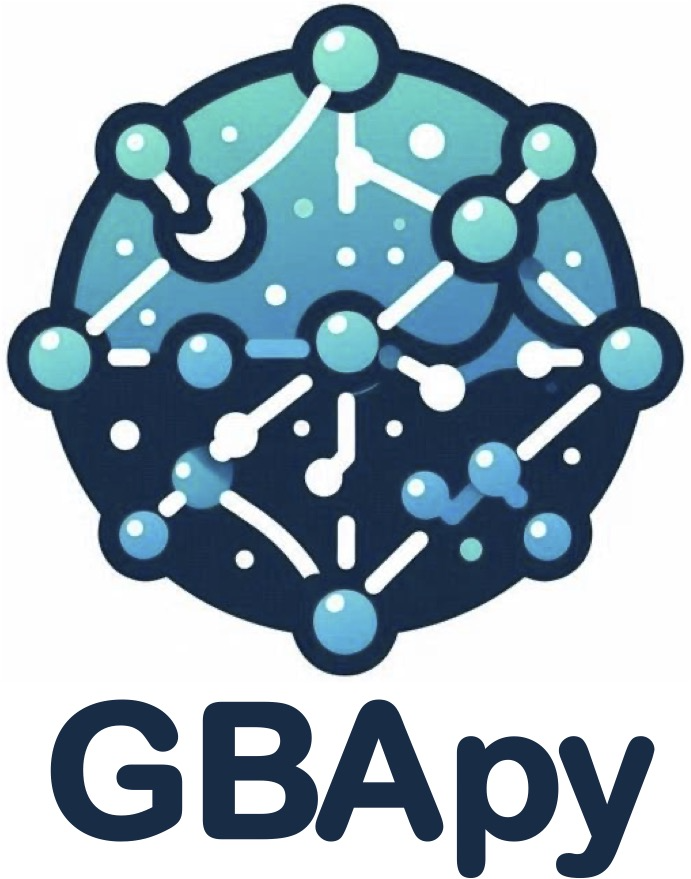

</div>

# Table of contents <a id="table_of_contents"></a>

- [1. Objective](#objective)
- [2. Load the model builder](#load)
- [3. Detect the list of inactive reactions in the original model](#detect_FBA_inactive)
- [4. Remove the list of FBA inactive reactions](#remove_FBA_inactive)
- [5. Backup the reduced model before building the final CGM](#backup)

# In summary

<div align="center" style="max-width:850px;display:block;margin:auto;">

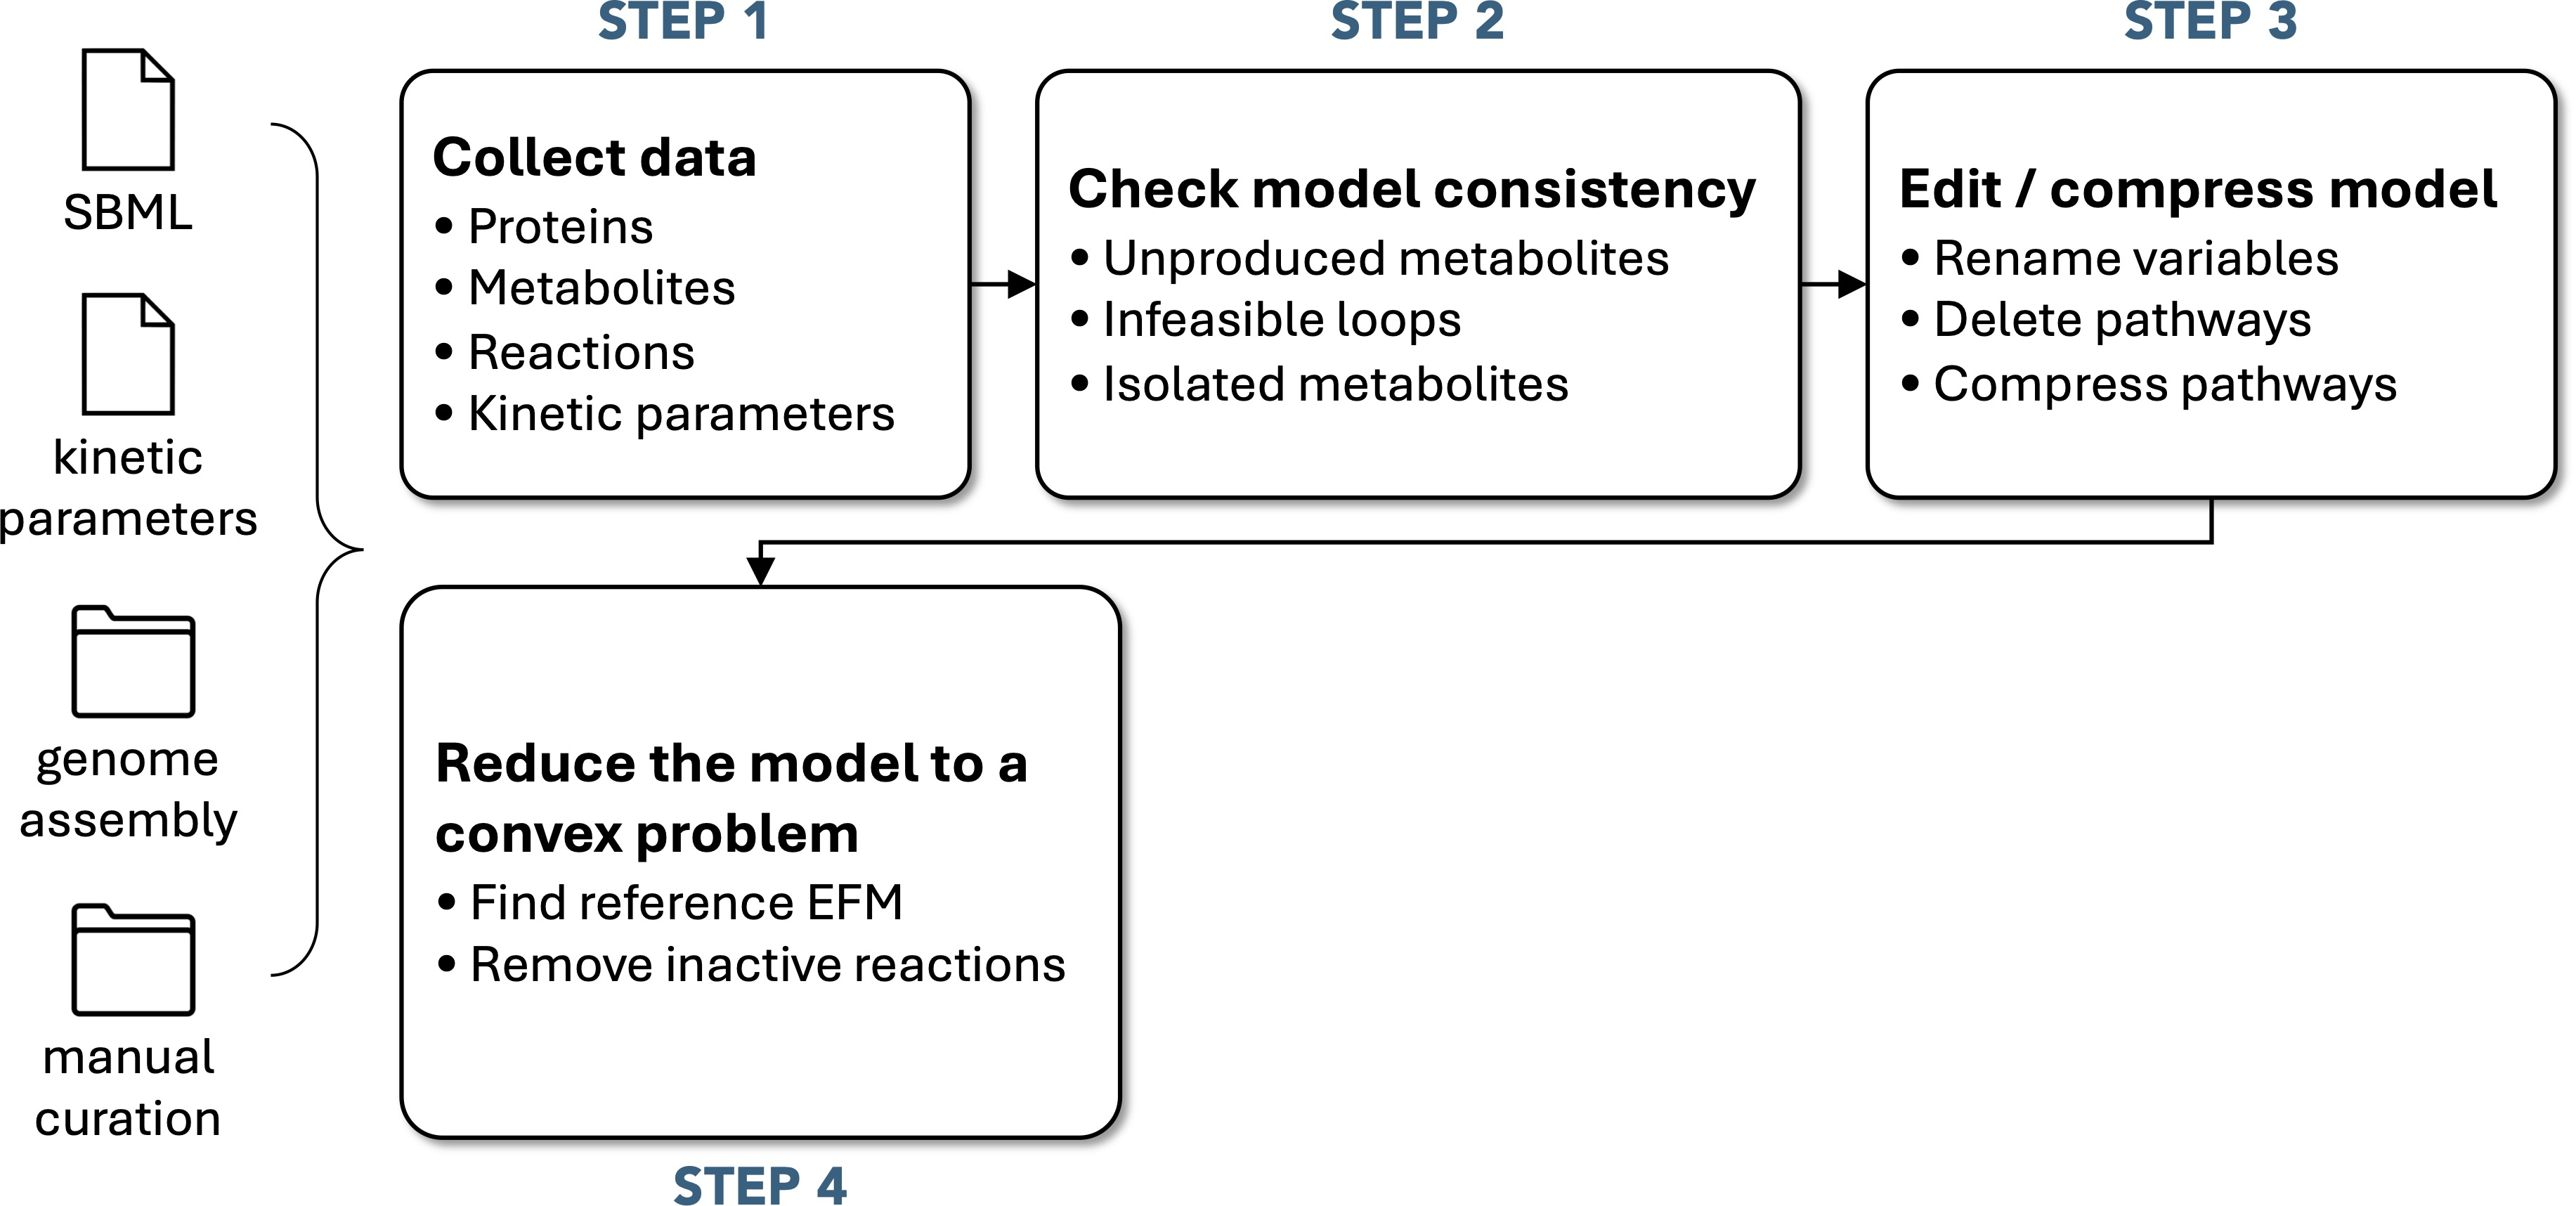

</div>

<div align="center">
<strong>At the beginning of each step of the tutorial, the GBApy methods used are listed</strong>.
</div>

# 1. Objective <a id="objective"></a>

[&#10148; Back to the table of contents](#table_of_contents)

In tutorial 3, we simplified some metabolic pathways to reduce model's complexity. Nonetheless, such a model cannot be easily optimized as its matrix is not full column rank (see below). Indeed, it has been shown that if the matrix is full column rank, the problem is proven to be convex, with a single optimal solution.

In this tutorial, we will reduce the model by finding an EFM and remove inactive reactions. Many linear approaches can be used to obtain an EFM (<em>e.g.</em> FBA, pFBA, Gecko, or RBA approaches). As a first approach, we will use a standard FBA optimization by reconstructing the original model conditions.

As mass conservation discrepancies can still remain between FBA and CGM versions, it will be later required (tutorial 5) to run a first CGM optimization, and remove remaining inactive reactions to reach a EFM into the CGM.

# 2. Load the model builder <a id="load"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.load_builder( path )</code> | Load a CGM builder from a backup |

</div>

The CGM builder is loaded from the backup created in tutorial 3.
We also re-load the original SBML model of a minimal cell.

In [1]:
import gba
import cobra
import numpy as np

builder    = gba.load_builder("backup/mmsyn_build_3.cgmbuild")
sbml_model = cobra.io.read_sbml_model("data/manual_curation/MMSYN_annotated.xml")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-15
Read LP format model from file /var/folders/5h/n0xqh1xj2zg6yyd747k95bc80000gn/T/tmp02qteoz0.lp
Reading time = 0.00 seconds
: 156 rows, 376 columns, 1560 nonzeros


# 3. Detect the list of inactive reactions in the reconstructed FBA solution <a id="detect_FBA_inactive"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Builder.build_FBA_model( enforced_reactions )</code> | Reconstruct an FBA version of the model, given an optional list of reactions with enforced values |

</div>

To detect inactive reactions, we first reconstruct the FBA model, using the biomass function of the original JVCI-syn3A model, minus missing reactants removed from the current model build. To increase the realism of the solution, we enforce positive values for the production reactions we have added in previous tutorials, and water transport.

We find 35 inactive reactions. When all these reactions will be removed, we will have reached a FBA elementary flux mode (EFM).

In [2]:
# First, we set up water transport as irreversible
builder.reactions["H2Ot"].lb = 0.0

# Second we caculate the FBA solution with enforced positive fluxes
# for synthesis reactions and water transport
enforced_reactions = {"tRNAP": 1e-8,
                      "RNAP": 1e-8,
                      "ACP_transl": 1e-8,
                      "PdhC_transl": 1e-8,
                      "dUTPase_transl": 1e-8,
                      "H2Ot": 1e-8}
builder.build_FBA_model(enforced_reactions)
print(">", len(builder.inactive_reactions), "reactions to remove")
builder.inactive_reactions

> 35 reactions to remove


['ACALDt',
 'ADEt2',
 'ADNabc',
 'CO2t',
 'CTPDP',
 'DCDPMP',
 'DCTPDP',
 'DCTPMP',
 'DURIK1',
 'DURIabc',
 'DUTPDP',
 'GAPDP',
 'GSNabc',
 'GUAt2',
 'NADK',
 'NAt3',
 'NTD1',
 'NTD5',
 'NTD6',
 'NTD8',
 'NTD9',
 'PDH_E1',
 'PDH_E2',
 'PGK2',
 'PPM',
 'PUNP1',
 'PUNP3',
 'PYK',
 'PYK3',
 'PYK9',
 'PYRt2r',
 'RNDR1',
 'RNDR2',
 'RNDR3',
 'RNDR4']

# 4. Remove the list of FBA inactive reactions <a id="remove_FBA_inactive"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Builder.reset_conversion()</code> | Reset the conversion to GBA units |
| <code>gba.Builder.remove_reaction()</code> | Remove a reaction from the CGM builder |
| <code>gba.Builder.remove_metabolite()</code> | Remove a metabolite from the CGM builder |
| <code>gba.Builder.build_FBA_model( enforced_reactions )</code> | Reconstruct an FBA version of the model, given an optional list of reactions with enforced values |

</div>

We will now remove all these reactions pathway by pathway.

In [3]:
builder.reset_conversion()

# Remove inactive transporters
reactions = ["ACALDt", "ADEt2", "ADNabc", "CO2t", "GUAt2", "NAt", "NAt3", "GSNabc", "PYRt2r"]
metabolites = ["x_acald", "x_ade", "x_adn", "adn", "x_co2", "x_gua", "x_na1", "na1", "x_gsn", "x_pyr"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# Remove deoxyuridine metabolism
metabolites = ["x_duri", "duri"]
reactions   = ["DURIabc", "DURIK1", "NTD1"]#, "DCMPDA", "CTPSDUMP"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# PUNP reactions
reactions = ["PUNP1", "PUNP3", "PPM"]
metabolites = ["r1p"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# NTD reactions
reactions = ["NTD5", "NTD6", "NTD8", "NTD9"]
metabolites = ["gsn"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# RNDR reactions
reactions = ["RNDR1", "RNDR2", "RNDR3", "RNDR4"]
metabolites = []
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# PYK reactions
reactions = ["PYK", "PYK3", "PYK9"]
metabolites = ["dudp", "dutp"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# PGK reactions
reactions = ["PGK2"]
metabolites = []
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# NADP metabolism
reactions = ["GAPDP", "NADK"]
metabolites = []
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# Remove acetaldehyde metabolism
reactions   = ["PDH_E1", "PDH_E2"]
metabolites = ["co2", "acdhlpl_PdhC"]
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)

# Nucleotides metabolism
reactions = ["DUTPDP", "CTPDP", "DCDPMP", "DCTPDP", "DCTPMP"]
metabolites = []
builder.remove_reactions(reactions)
builder.remove_metabolites(metabolites)


In [4]:
builder.build_FBA_model(enforced_reactions)
print(">", len(builder.inactive_reactions), "reactions to remove")

> 0 reactions to remove


In [5]:
all_reactions = ["ACALDt", "ADEt2", "ADNabc", "CO2t", "GUAt2", "NAt", "NAt3", "GSNabc", "PYRt2r",
                 "DURIabc", "DURIK1", "NTD1", "PUNP1", "PUNP3", "PPM", "NTD5", "NTD6", "NTD8", "NTD9",
                 "RNDR1", "RNDR2", "RNDR3", "RNDR4", "PYK", "PYK3", "PYK9", "PGK2", "GAPDP", "NADK",
                 "PDH_E1", "PDH_E2", "DUTPDP", "CTPDP", "DCDPMP", "DCTPDP", "DCTPMP"]
f = open("./output/JCVISYN3A_inactive_FBA_reactions.csv", "w")
f.write("reaction_id\n")
f.write("\n".join(all_reactions)+"\n")
f.close()

all_metabolites = ["x_acald", "x_ade", "x_adn", "adn", "x_co2", "x_gua", "x_na1", "na1", "x_gsn",
                   "x_pyr", "x_duri", "duri", "r1p", "gsn", "dudp", "dutp", "co2", "acdhlpl_PdhC"]
f = open("./output/JCVISYN3A_inactive_FBA_metabolites.csv", "w")
f.write("metabolite_id\n")
f.write("\n".join(all_metabolites)+"\n")
f.close()

print("Nb inactive FBA reactions:", len(all_reactions))
print("Nb inactive FBA metabolites:", len(all_metabolites))

Nb inactive FBA reactions: 36
Nb inactive FBA metabolites: 18


# 5. Final model check and backup <a id="check"></a>

[&#10148; Back to the table of contents](#table_of_contents)

<div align="center">

| GBApy method | Description |
| ------ | ----------- |
| <code>gba.Builder.check_model( test_structure )</code> | Check connectivity issues in the model |
| <code>gba.Builder.summary()</code> | Display a summary of a CGM builder |
| <code>gba.Builder.build_FBA_model()</code> | Reconstruct a FBA model from scratch |
| <code>gba.backup_builder( builder, name, path )</code> | Backup a CGM builder |

</div>

By running a complete test on the model, we see that we did not introduce errors.

In [6]:
builder.check_model(test_structure=True)

❯ Info,No missing mass in the model.


❯ Info,No missing kinetic parameters in the model.


❯ Info,No connectivity issues in the model.


❯ Info,No unproduced metabolites in the model.


❯ Info,No infeasible loops in the model.


❯ Info,No isolated metabolites in the model.


In [7]:
builder.summary()

CGM build GBA_MMSYN summary General 
 
 
 Category 
 Count 
 
 
 
 
 Known proteins 
 461 
 
 
 Modeled proteins 
 174 
 
 
 Metabolites 
 138 
 
 
 Reactions 
 118 
 
 
 Metabolites 
 
 
 Category 
 Count 
 Percentage 
 
 
 
 
 Small molecules 
 115 
 83.33% 
 
 
 Macro-molecules 
 19 
 13.77% 
 
 
 DNA(s) 
 1 
 0.72% 
 
 
 RNA(s) 
 3 
 2.17% 
 
 
 Proteins 
 0 
 0.00% 
 
 
 Unknown 
 0 
 0.00% 
 
 
 Reaction types 
 
 
 Category 
 Count 
 Percentage 
 
 
 
 
 Metabolic 
 93 
 78.81% 
 
 
 Transport 
 25 
 21.19% 
 
 
 Exchange 
 0 
 0.00% 
 
 
 Reaction directions 
 
 
 Category 
 Count 
 Percentage 
 
 
 
 
 Forward 
 68 
 57.63% 
 
 
 Backward 
 1 
 0.85% 
 
 
 Reversible 
 49 
 41.53%

In [8]:
gba.backup_builder(builder, "mmsyn_build_4", "./backup")